In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import scipy.stats as stat
import sys
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Visulization code, got at : https://github.com/jzliu-100/visualize-neural-network/blob/master/VisualizeNN.py  , with little bit of modification.

from matplotlib import pyplot
from math import cos, sin, atan
from palettable.tableau import Tableau_10
from time import localtime, strftime
import numpy as np

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius, id=-1):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)
        pyplot.gca().text(self.x, self.y-0.15, str(id), size=10, ha='center')

class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 12
        self.horizontal_distance_between_neurons = 8
        self.neuron_radius = 1
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, weight=0.4, textoverlaphandler=None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)

        # assign colors to lines depending on the sign of the weight
        color=Tableau_10.mpl_colors[0]
        if weight > 0: color=Tableau_10.mpl_colors[2]

        # assign different linewidths to lines depending on the size of the weight
        abs_weight = abs(weight)        
        if abs_weight > 0.5: 
            linewidth = 4* abs_weight
        elif abs_weight > 0.8: 
            linewidth =  2* abs_weight
        else:
            linewidth = abs_weight

        # draw the weights and adjust the labels of weights to avoid overlapping
        if abs_weight > 0.01: 
            # while loop to determine the optimal locaton for text lables to avoid overlapping
            index_step = 2
            num_segments = 10   
            txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
            txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments
            while ((not textoverlaphandler.getspace([txt_x_pos-0.5, txt_y_pos-0.5, txt_x_pos+0.5, txt_y_pos+0.5])) and index_step < num_segments):
                index_step = index_step + 1
                txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
                txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments

            # print("Label positions: ", "{:.2f}".format(txt_x_pos), "{:.2f}".format(txt_y_pos), "{:3.2f}".format(weight))
            a=pyplot.gca().text(txt_x_pos, txt_y_pos, "{:3.2f}".format(weight), size=8, ha='center')
            a.set_bbox(dict(facecolor='white', alpha=0))
            # print(a.get_bbox_patch().get_height())

        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment), linewidth=linewidth, color=color)
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, weights=None, textoverlaphandler=None):
        j=0 # index for neurons in this layer
        for neuron in self.neurons:            
            i=0 # index for neurons in previous layer
            neuron.draw( self.neuron_radius, id=j+1 )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weights[i,j], textoverlaphandler)
                    i=i+1
            j=j+1
        
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

# A class to handle Text Overlapping
# The idea is to first create a grid space, if a grid is already occupied, then
# the grid is not available for text labels.
class TextOverlappingHandler():
    # initialize the class with the width and height of the plot area
    def __init__(self, width, height, grid_size=0.2):
        self.grid_size = grid_size
        self.cells = np.ones((int(np.ceil(width / grid_size)), int(np.ceil(height / grid_size))), dtype=bool)

    # input test_coordinates(bottom left and top right), 
    # getspace will tell you whether a text label can be put in the test coordinates
    def getspace(self, test_coordinates):
        x_left_pos = int(np.floor(test_coordinates[0]/self.grid_size))
        y_botttom_pos = int(np.floor(test_coordinates[1]/self.grid_size))
        x_right_pos = int(np.floor(test_coordinates[2]/self.grid_size))
        y_top_pos = int(np.floor(test_coordinates[3]/self.grid_size))
        if self.cells[x_left_pos, y_botttom_pos] and self.cells[x_left_pos, y_top_pos] \
        and self.cells[x_right_pos, y_top_pos] and self.cells[x_right_pos, y_botttom_pos]:
            for i in range(x_left_pos, x_right_pos):
                for j in range(y_botttom_pos, y_top_pos):
                    self.cells[i, j] = False

            return True
        else:
            return False

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self, weights_list=None):
        # vertical_distance_between_layers and horizontal_distance_between_neurons are the same with the variables of the same name in layer class
        vertical_distance_between_layers = 12
        horizontal_distance_between_neurons = 8
        overlaphandler = TextOverlappingHandler(\
            self.number_of_neurons_in_widest_layer*horizontal_distance_between_neurons,\
            len(self.layers)*vertical_distance_between_layers, grid_size=0.2 )

        pyplot.figure(figsize=(25, 25))
        for i in range( len(self.layers) ):
            layer = self.layers[i]                                
            if i == 0:
                layer.draw( layerType=0 )
            elif i == len(self.layers)-1:
                layer.draw( layerType=-1, weights=weights_list[i-1], textoverlaphandler=overlaphandler)
            else:
                layer.draw( layerType=i, weights=weights_list[i-1], textoverlaphandler=overlaphandler)

        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        figureName='ANN_'+strftime("%Y%m%d_%H%M%S", localtime())+'.png'
        pyplot.savefig(figureName, dpi=300, bbox_inches="tight")
        pyplot.show()

class DrawNN():
    # para: neural_network is an array of the number of neurons 
    # from input layer to output layer, e.g., a neural network of 5 nerons in the input layer, 
    # 10 neurons in the hidden layer 1 and 1 neuron in the output layer is [5, 10, 1]
    # para: weights_list (optional) is the output weights list of a neural network which can be obtained via classifier.coefs_
    def __init__( self, neural_network, weights_list=None ):
        self.neural_network = neural_network
        self.weights_list = weights_list
        # if weights_list is none, then create a uniform list to fill the weights_list
        if weights_list is None:
            weights_list=[]
            for first, second in zip(neural_network, neural_network[1:]):
                tempArr = np.ones((first, second))*0.4
                weights_list.append(tempArr)
            self.weights_list = weights_list
        
    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw(self.weights_list)

In [3]:
#data generation

def ygeneration(X):
  fx = (X['X1']*np.sqrt(np.abs(X['X4'])+1)+ np.sin(X['X3'])
   - np.abs(X['X2'])/(np.sqrt(np.abs(X['X5'])+1)) +1.5*np.abs(X['X6']) +X['X7'])
  p = 1/ (1+np.exp(-fx))
  y=[]
  for i in range(len(p)):
    y.append(np.random.binomial(n=1, p=p[i], size=1 ))
  return np.ravel(y)

Xtrain = {}
for i in range(7):
  if i <=2:
    Xtrain[f'X{i+1}'] = np.random.uniform(-10,10,10000)
  else:
    Xtrain[f'X{i+1}'] = np.random.normal(loc=0, scale = np.sqrt(10),size = 10000)
Xtrain = pd.DataFrame(Xtrain)


Xtest = {}
for i in range(7):
  if i <=2:
    Xtest[f'X{i+1}'] = np.random.uniform(-10,10,10000)
  else:
    Xtest[f'X{i+1}'] = np.random.normal(loc=0, scale = np.sqrt(10),size = 10000)
Xtest = pd.DataFrame(Xtest)

ytrain = ygeneration(Xtrain)
ytest = ygeneration(Xtest)

In [4]:
# making cancdidates
a = [1,2,3,4]
b = [2,3,4,5]
c = []
for i in range(len(a)):
  for j in range(len(b)):
    c.append([a[i],b[j]])
d=[]
for i in range(len(c)):
  d.append([c[i][0]]*c[i][1])


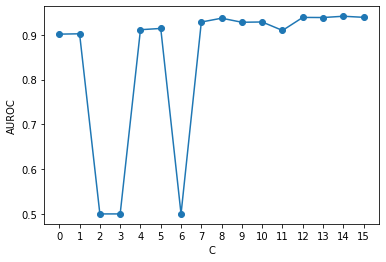

the best : 14
the best : [4, 4, 4, 4]


In [5]:
#1. fitting using MLPClassifier
mlpclassifier = {}
auroc = []
for i in range(len(d)):
  mlpclassifier[f'MLPClassifier{c[i]}'] = MLPClassifier(hidden_layer_sizes=d[i])
  mlpclassifier[f'MLPClassifier{c[i]}'].fit(Xtrain,ytrain)
  auroc.append(roc_auc_score(ytest,mlpclassifier[f'MLPClassifier{c[i]}'].predict(Xtest) ))

#2. drawing graphs
plt.plot(auroc ,marker="o")
plt.xticks(range(len(c)))
plt.xlabel('C')
plt.ylabel('AUROC')
plt.show()

#3. the highest AUROC one
highest = np.argmax(auroc)
print('the best :', highest)
print('the best :', d[highest])


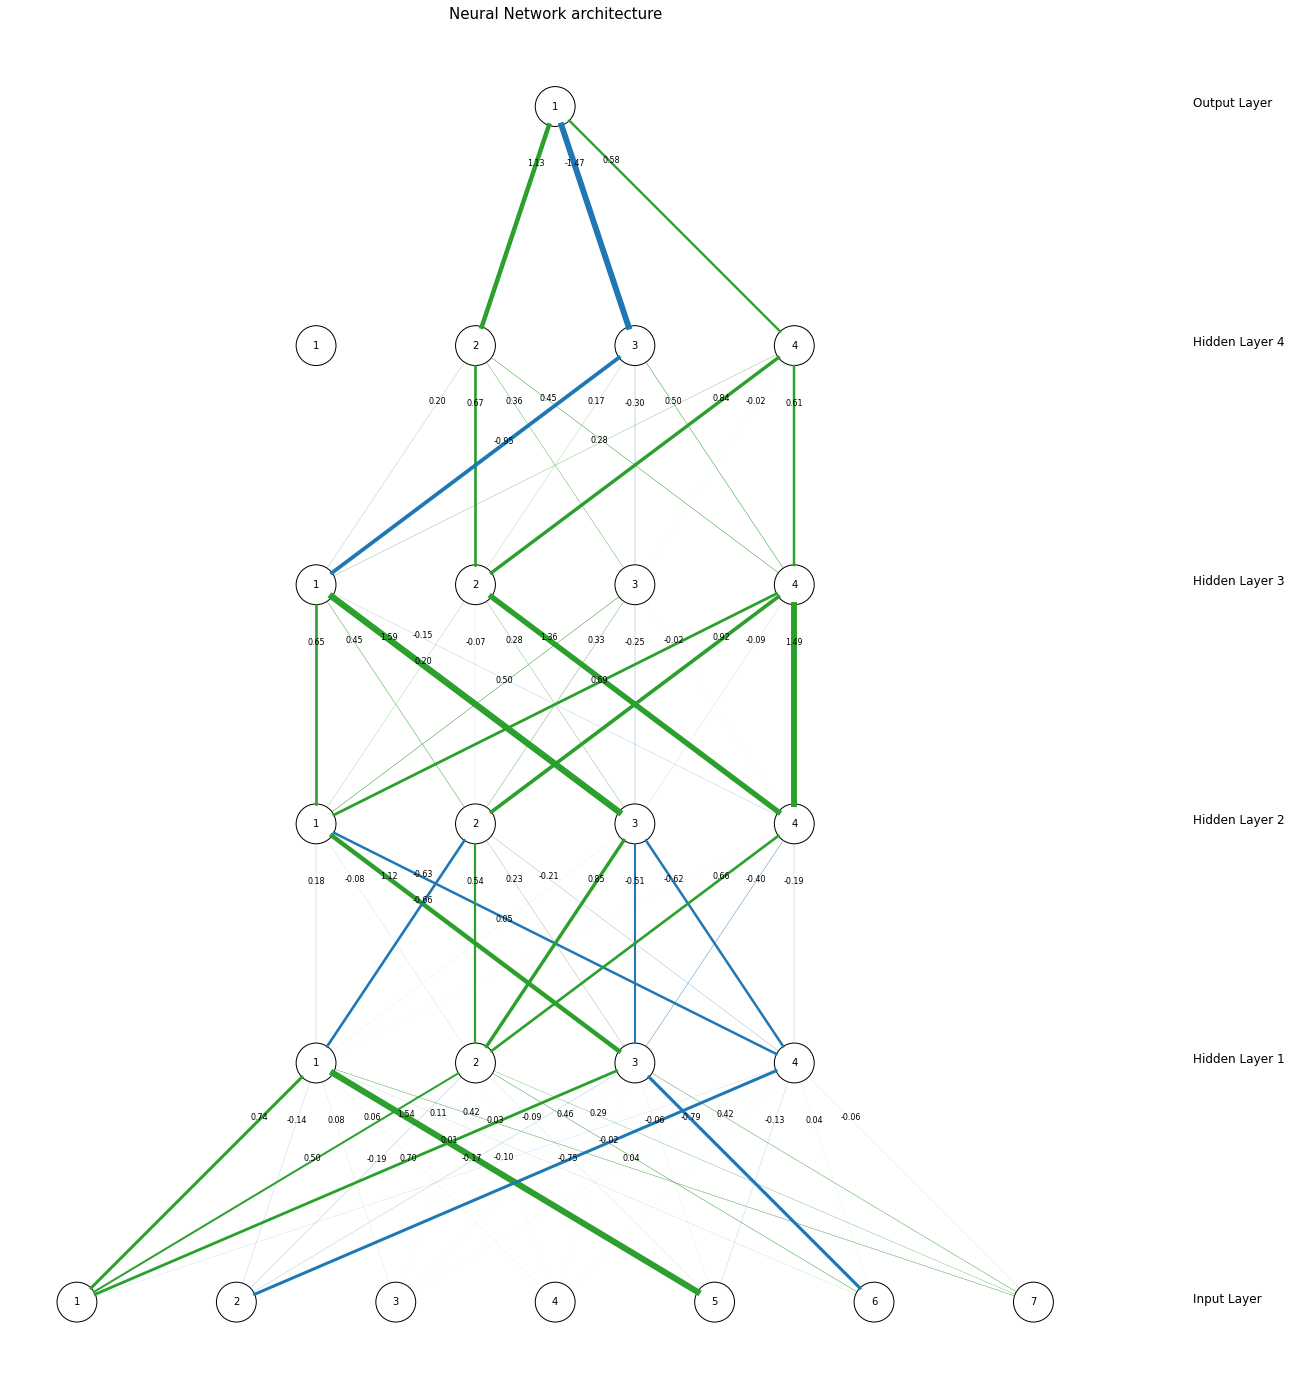

In [6]:
#4. network visualizing
network=DrawNN([7] + d[highest] +[1], mlpclassifier[f'MLPClassifier{c[highest]}'].coefs_)
network.draw()

In [7]:
#5 result
sys.stdout = open('result.txt','w')
print('    ')
print('Neural Network')
print( 'Confusion Matrix( NN)')
print('----------------------------------------------------')
confusion_tst = confusion_matrix(ytest, 
                                 mlpclassifier[f'MLPClassifier{c[highest]}'].predict(Xtest))

accu_tst = 0
for i in range(len(np.unique(ytest))):
  accu_tst = accu_tst + confusion_tst[i][i]
accuracy_tst = accu_tst / len(ytest)

print('           predicted class \n Actual 1 ' ,confusion_tst[0], 
      '\n class  2 ', confusion_tst[1])
for i in range(2, len(np.unique(ytest))) :
  print(f'        {i+1} ', confusion_tst[i])
print('model summary(NN)')
print('----------------------------------')
print('Overall accuracy = ' ,accuracy_tst)